## Import Libraries

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import loads
from sklearn.cluster import KMeans
import numpy as np

## Read In Data

In [5]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")

## Format Data
BUSINESS_SITES.shp file's coordinates are not in CRS

In [6]:
gdf = gdf.to_crs(crs='EPSG:4326')
gdf = gdf[gdf['POINT_X']!=0]
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

## Bin Data into ~1/4 Hexbins


(note - gridsize was manually calculated based on width of SD County to generate roughly 1/4 mile radius hexbins:
SD County is roughly 86 miles east to west, and the grid size takes the quantity of hexbins by width
)

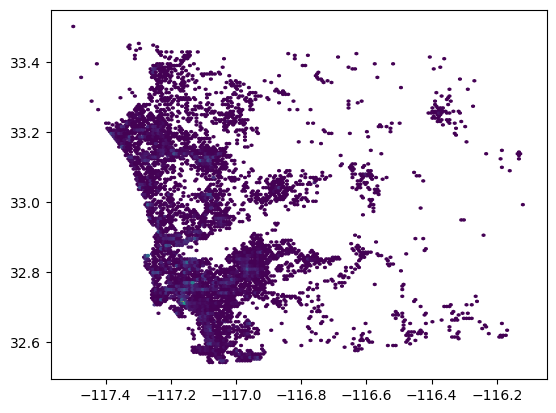

In [7]:
hexes = matplotlib.pyplot.hexbin( x= gdf['x'], y=gdf['y'],mincnt=1,gridsize=86*2)

In [8]:
hexbins = gpd.points_from_xy(x=[i[0] for i in hexes.get_offsets()],y=[i[1] for i in hexes.get_offsets()])[1:]

In [9]:
hexbins

<GeometryArray>
[<POINT (-117.475 33.356)>, <POINT (-117.443 33.288)>,
 <POINT (-117.427 33.395)>, <POINT (-117.394 33.211)>,
 <POINT (-117.386 33.201)>, <POINT (-117.386 33.211)>,
 <POINT (-117.378 33.192)>, <POINT (-117.378 33.201)>,
 <POINT (-117.378 33.221)>,  <POINT (-117.37 33.182)>,
 ...
 <POINT (-116.193 32.616)>, <POINT (-116.185 32.616)>,
 <POINT (-116.185 32.654)>,   <POINT (-116.185 33.1)>,
 <POINT (-116.185 33.148)>, <POINT (-116.169 32.635)>,
  <POINT (-116.161 33.09)>, <POINT (-116.137 33.138)>,
 <POINT (-116.128 33.138)>,  <POINT (-116.12 32.993)>]
Length: 4535, dtype: geometry

Merge the data with the newly generated hexbins

In [10]:
left_merge = gpd.GeoDataFrame(hexbins, geometry=0)

In [11]:
full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')

/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_11464/318931066.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')
/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


## Apply Manually Created Categories to Businesses

In [12]:
labels = pd.read_csv('../generate_labels.csv')
final_merge = full_merge.merge(labels, how='left', left_on='BUSTYPE',right_on='Items')
final_merge = final_merge[~final_merge['Categories'].isna()]

## Groupby Each Hexbin and Count the # of Businesses in Each Bin

In [13]:
index_and_counts = final_merge\
    .groupby('index_left').count()\
    .sort_values(by='x').reset_index()[['index_left','APN',]]\
    .rename(columns={'APN':'Count'})

## Generate Center Points of Each Hexbin

In [14]:
def get_x(index):
    return hexbins[index].x
def get_y(index):
    return hexbins[index].y
index_and_counts['x'] = index_and_counts['index_left'].apply(get_x)
index_and_counts['y'] = index_and_counts['index_left'].apply(get_y)
index_and_counts['geometry'] = gpd.points_from_xy(index_and_counts['x'], index_and_counts['y'])
df = gpd.GeoDataFrame(index_and_counts)

## Use the 70 Largest Hexbins as 'Centers' For Clustering

In [15]:
df['is_center'] = df['Count']>=df['Count'].sort_values(ascending=False).reset_index(drop=True)[70]
cluster_centers = df[df['is_center']==True][['x', 'y']].values
other_points = df[['x', 'y']].values
k = len(cluster_centers)
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans.fit(other_points)
df['cluster'] = kmeans.labels_

Text(0.5, 1.0, 'Overall Clusters')

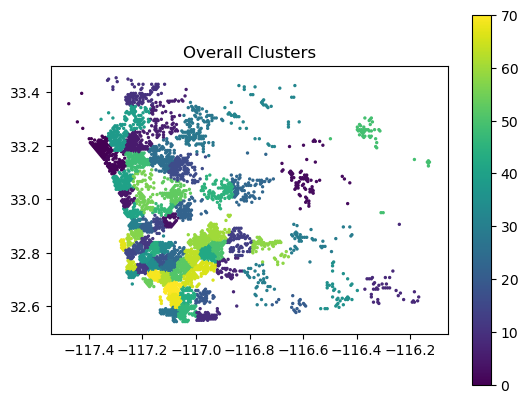

In [16]:
df.plot(column='cluster', legend=True, markersize=2).set_title('Overall Clusters')

In [17]:
df

,index_left,Count,x,y,geometry,is_center,cluster
0,2081,1,-116.679066,32.794604,POINT (-116.67907 32.79460),False,58
1,1225,1,-117.072903,33.065672,POINT (-117.07290 33.06567),False,53
2,3331,1,-117.092997,32.944659,POINT (-117.09300 32.94466),False,3
3,3478,1,-117.068884,33.080193,POINT (-117.06888 33.08019),False,16
4,1221,1,-117.072903,32.997905,POINT (-117.07290 32.99790),False,53
...,...,...,...,...,...,...,...
3971,750,365,-117.161316,32.746199,POINT (-117.16132 32.74620),True,34
3972,165,420,-117.273841,32.843009,POINT (-117.27384 32.84301),True,67
3973,3001,464,-117.157297,32.712315,POINT (-117.15730 32.71232),True,69
3974,710,569,-117.169353,32.717156,POINT (-117.16935 32.71716),True,69


## Import Tracts Data

In [18]:
tracts = gpd.read_file('../data/tracts.csv').drop(columns=['geometry'])
tracts['the_geom'] = tracts['the_geom'].apply(loads)
tracts = tracts.set_geometry('the_geom')

In [19]:
poly_df = full_merge.merge(df[['index_left','cluster']],how='left')
geometry = poly_df['geometry'].apply(Point)
gpdf = gpd.GeoDataFrame(poly_df, geometry=geometry)

In [20]:
pre_groupby = tracts.sjoin(gpdf.drop(columns=['index_left']), how='left', predicate='contains')
groupby_tracts = pre_groupby.groupby('the_geom')['cluster']

/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


## Create Final Clusters by merging Hexbins onto Nearest Tracts

<Axes: >

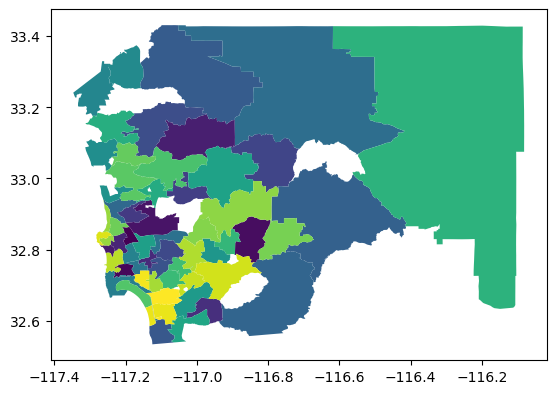

In [21]:
# use the most common cluster type in the tract as it's cluster
min_per_tract = 10
clusters_tracts = groupby_tracts.agg(lambda x:x.value_counts().index[0] if x.any() and x.value_counts().index[0]>min_per_tract else -1).to_frame()
clusters_tracts = clusters_tracts[clusters_tracts['cluster']!=-1].reset_index()
clusters_tracts = clusters_tracts.set_geometry('the_geom')
dissolved = clusters_tracts.dissolve(by='cluster').reset_index()
dissolved.plot(column='cluster')

<Axes: ylabel='Frequency'>

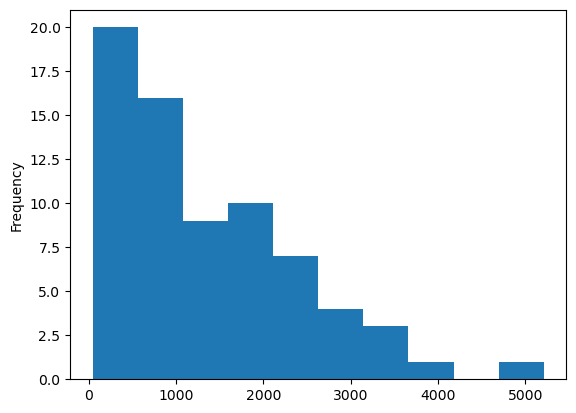

In [22]:
pre_groupby.groupby('cluster').count()['the_geom'].plot(kind='hist')

In [27]:
dissolved.to_file('../output/overall_clusters.shp')